In [1]:
import os
import datetime
import time
from IPython.display import clear_output

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from ClusterDataset import ClusterDataset
from training import *
from data_statistics import *

from GNN_TrackLinkingNet import GNN_TrackLinkingNet, FocalLoss, EarlyStopping, weight_init

from IPython.display import display

2025-05-15 17:05:00.819439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747321500.837117     439 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747321500.842786     439 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-15 17:05:00.866497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo_new/"
data_folder_training = "/eos/user/c/czeh/graph_data"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder)
dataset_test = ClusterDataset(data_folder_test, hist_folder, test=True)

In [4]:
print_dataset_statistics(dataset_training)

Number of events in training dataset: 299


/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

Number of nodes: 8710
Mean Number of nodes: 29.130434782608695
Number of edges: 53836
Mean Number of edges: 180.05351170568562
Number of positive edges: 47377
Mean Number of positive edges: 158.45150756835938
Number of negative edges: 6459
Mean Number of negative edges: 21.602006912231445


In [5]:
print_dataset_statistics(dataset_test)

Number of events in training dataset: 100
Number of nodes: 2891
Mean Number of nodes: 28.91
Number of edges: 17805
Mean Number of edges: 178.05
Number of positive edges: 15627
Mean Number of positive edges: 156.27000427246094
Number of negative edges: 2178
Mean Number of negative edges: 21.780000686645508


In [6]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [7]:
epochs = 200
start_epoch = 0

model = GNN_TrackLinkingNet(input_dim = dataset_training.get(0).x.shape[1], 
                                edge_feature_dim=dataset_training.get(0).edges_features.shape[1],
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True,
                               dropout=0.3)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
loss_obj = FocalLoss(alpha=0.45, gamma=2)
early_stopping = EarlyStopping(patience=20, delta=-2)

model.apply(weight_init)

# weights = torch.load(model_folder + "/model_epoch_100_loss_26.8352_2025-05-13.pt", weights_only=True)
# model.load_state_dict(weights["model_state_dict"])
# optimizer.load_state_dict(weights["optimizer_state_dict"])
# start_epoch = weights["epoch"]

GNN_TrackLinkingNet(
  (inputnetwork): Sequential(
    (0): Linear(in_features=29, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (edge_inputnetwork): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (attention_direct): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=1, bias=True)
    (4): Sigmoid()
  )
  (attention_reverse): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)


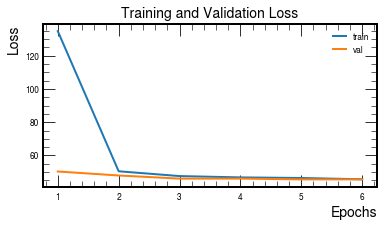

2

Epoch: 1


Training epoch 1: 100%|██████████| 299/299 [00:05<00:00, 52.44it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 90.16it/s]


Epoch: 2


Training epoch 2: 100%|██████████| 299/299 [00:04<00:00, 60.05it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 92.92it/s]


Epoch: 3


Training epoch 3: 100%|██████████| 299/299 [00:04<00:00, 61.16it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 93.18it/s]


Epoch: 4


Training epoch 4: 100%|██████████| 299/299 [00:05<00:00, 58.91it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 80.60it/s]


Epoch: 5


Training epoch 5: 100%|██████████| 299/299 [00:04<00:00, 60.18it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 98.18it/s]


Epoch: 6


Training epoch 6: 100%|██████████| 299/299 [00:05<00:00, 57.37it/s]


Validation step


Validation: 100%|██████████| 100/100 [00:01<00:00, 69.88it/s]


KeyboardInterrupt: 

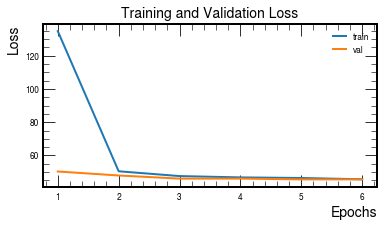

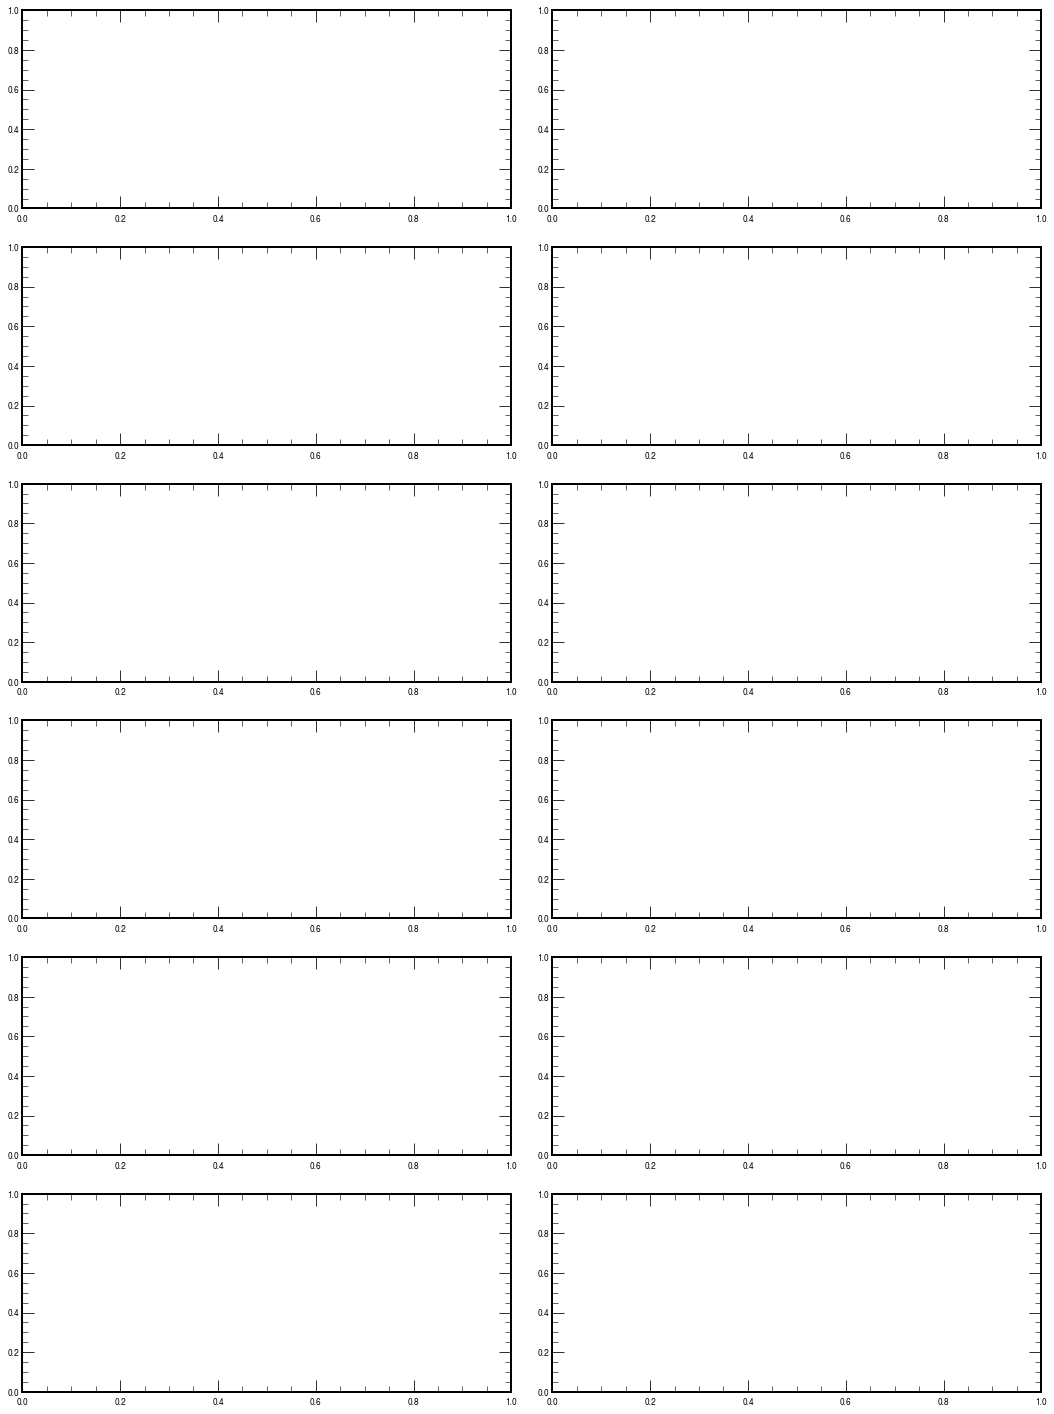

In [8]:
# decision_th = 0.5
os.makedirs(model_folder, exist_ok=True)

train_loss_hist = []
val_loss_hist = []
edge_features = True
date = f"{datetime.now():%Y-%m-%d}"

fig_loss, ax_loss = plt.subplots(1, 1)
fig_loss.set_figwidth(6)
fig_loss.set_figheight(3)

fig_analysis, ax_analysis = plt.subplots(6, 2)
fig_analysis.set_figwidth(15)
fig_analysis.set_figheight(20)
fig_analysis.tight_layout(pad=2.0)

display_loss = display(1, display_id=True)
display_analysis = display(2, display_id=True)

for epoch in range(start_epoch, epochs):
    print(f'Epoch: {epoch+1}')
    
    loss = train(model, optimizer, train_dl, epoch+1, device=device, edge_features=edge_features, loss_obj=loss_obj)
    train_loss_hist.append(loss)
    
    val_loss, pred, y = test(model, test_dl, epoch+1, loss_obj=loss_obj, edge_features=edge_features, device=device)
    val_loss_hist.append(val_loss)
    
    ax_loss.clear()
    plot_loss(train_loss_hist, val_loss_hist, ax=ax_loss)
    display_loss.update(fig_loss)
    time.sleep(1)
    
    early_stopping(model, val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping after {epoch+1} epochs")
        early_stopping.load_best_model(model)
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
                
        plot_validation_results(pred, y, save=True, ax=ax_analysis, output_folder=model_folder, file_suffix=f"epoch_{epoch+1}_date_{date}")
        display_analysis.update(fig_analysis)
        time.sleep(1)
        break
      
    if ((epoch+1)%60==0 or epoch+1==epochs):
        print(f'Epoch: {epoch+1}')
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
            
        plot_validation_results(pred, y, save=True, ax=ax_analysis, output_folder=model_folder, file_suffix=f"epoch_{epoch+1}_date_{date}")
        display_analysis.update(fig_analysis)
        time.sleep(1)
        
        save_model(model, epoch, optimizer, loss, val_loss, output_folder=model_folder, filename=f"model_epoch_{epoch+1}_date_{date}_loss_{loss:.4f}.pt")
    elif ((epoch+1)%20==0):
        print(f'Epoch: {epoch+1}')
        
        for axes in ax_analysis:
            for ax in axes:
                ax.clear()
        plot_validation_results(pred, y, save=False, ax=ax_analysis) 
        display_analysis.update(fig_analysis)
        time.sleep(1)

    scheduler.step() 

tensor([[ 5.2983e+01, -2.8804e+01,  3.5685e+02,  2.4781e+00, -4.9795e-01,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0000e+00,
          7.0000e+00,  5.6327e+00,  5.6327e+00,  1.7408e-03,  2.4034e-09,
          1.8864e-09,  2.4375e-09,  9.9826e-01,  1.4128e-09,  3.5676e+02,
          3.6014e+02,  7.0922e-03,  9.2199e-02, -9.9000e+01],
        [ 4.8159e+01, -3.7245e+01,  3.5549e+02,  2.4650e+00, -6.5829e-01,
          1.2958e-01, -1.0879e-01,  9.8558e-01,  3.8365e+01,  2.0333e-02,
          4.5139e-03,  6.1085e+00,  1.0165e+00,  2.0633e-01,  4.3000e+01,
          6.0100e+02,  1.4065e+02,  1.2559e+02,  6.9290e-05,  5.6407e-13,
          3.7773e-13,  3.6084e-13,  9.9993e-01,  9.2487e-13,  3.2827e+02,
          3.6798e+02,  1.5248e-01,  9.2199e-02,  1.2200e+01],
        [ 4.7230e+01, -4.2085e+01,  3.7337e+02,  2.4756e+00, -7.2785e-01,
          6.0606e-02, -7.7778e-02,  9.9513e-01,  2.7030e+02,  

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray